In [1]:
# Cell 1: Import Required Libraries
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from sklearn.model_selection import train_test_split
import shutil
import random
import gc
from tensorflow.keras.backend import clear_session


2025-04-23 07:27:04.699348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745375224.713008   75821 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745375224.717144   75821 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 07:27:04.732737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Base directories
source_base = '/home/hamza/Desktop/RMI DATA (Copy)/sets'
dest_base = '/home/hamza/Desktop/RMI DATA (Copy)/flattened_jpg'

# Target categories
categories = ['Benign', 'Malignant', 'Normal']

# Create destination folders
for category in categories:
    os.makedirs(os.path.join(dest_base, category), exist_ok=True)

def collect_images():
    for root, _, files in os.walk(source_base):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Identify class and source subfolder
                path_parts = root.split(os.sep)
                class_name = None
                subfolder = path_parts[-1]  # Assumes last folder is like B4, M1, etc.

                # Determine class based on path
                if any('benign' in p.lower() for p in path_parts):
                    class_name = 'Benign'
                elif any('malignant' in p.lower() for p in path_parts):
                    class_name = 'Malignant'
                elif any('normal' in p.lower() for p in path_parts):
                    class_name = 'Normal'
                else:
                    continue  # Skip unknown categories

                # Construct new filename: e.g., B4-image1.jpg
                name_prefix = subfolder
                new_filename = f"{name_prefix}-{file}"

                # Ensure unique filename
                dest_dir = os.path.join(dest_base, class_name)
                name, ext = os.path.splitext(new_filename)
                counter = 1
                final_filename = new_filename
                while os.path.exists(os.path.join(dest_dir, final_filename)):
                    final_filename = f"{name}_{counter}{ext}"
                    counter += 1

                src_path = os.path.join(root, file)
                dest_path = os.path.join(dest_dir, final_filename)
                shutil.copy(src_path, dest_path)

collect_images()
print("Images transferred and renamed with subfolder prefix.")


Images transferred and renamed with subfolder prefix.


In [16]:

# Cell 2: Define Paths
benign_dir = "/home/hamza/Desktop/RMI DATA (Copy)/flattened_jpg/Benign"
malignant_dir = "/home/hamza/Desktop/RMI DATA (Copy)/flattened_jpg/Malignant"
augment_output_dir_b = "/home/hamza/Desktop/RMI DATA (Copy)/augmented_jpg/Benign"
augment_output_dir_m = "/home/hamza/Desktop/RMI DATA (Copy)/augmented_jpg/Malignant"
os.makedirs(augment_output_dir_b, exist_ok=True)
os.makedirs(augment_output_dir_m, exist_ok=True)


In [4]:

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Cell 3: Get images that start with specific patterns
image_files_b = [f for f in os.listdir(benign_dir) if f.startswith(('B', 'N', 'm')) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_files_m = [f for f in os.listdir(malignant_dir) if f.startswith(('P', 'm')) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Original benign images: {len(image_files_b)}")
print(f"Original malignant images: {len(image_files_m)}")


Original benign images: 282
Original malignant images: 290


In [52]:
# Cell 4: Calculate splits to maintain exact 80/10/10 ratio after augmentation

# Define target split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate number of original images for each class
original_benign_count = len(image_files_b)
original_malignant_count = len(image_files_m)
total_original = original_benign_count + original_malignant_count

print(f"Original dataset - Benign: {original_benign_count}, Malignant: {original_malignant_count}")

# Set fixed augmentation targets for each class
benign_aug_count = 0
malignant_aug_count = 0
total_augmented = benign_aug_count + malignant_aug_count

# Calculate total dataset size after augmentation
total_after_aug = total_original + total_augmented

# Calculate target sizes for each split to maintain exact 80/10/10 ratio
target_train_size = int(total_after_aug * train_ratio)
target_val_size = int(total_after_aug * val_ratio)
target_test_size = total_after_aug - target_train_size - target_val_size  # Ensure all images are accounted for

print(f"Total dataset size after augmentation: {total_after_aug}")
print(f"Target split sizes - Train: {target_train_size}, Val: {target_val_size}, Test: {target_test_size}")

# Calculate how many original images should go to training set
# Since all augmented images go to training, we need to subtract them from the target training size
original_for_train = target_train_size - total_augmented

# Calculate what percentage of original images should go to each split
train_percent_of_original = original_for_train / total_original
val_percent_of_original = target_val_size / total_original
test_percent_of_original = target_test_size / total_original

print(f"Original images distribution - Train: {train_percent_of_original:.2f}, Val: {val_percent_of_original:.2f}, Test: {test_percent_of_original:.2f}")

# Calculate split sizes for each class
benign_train_size = int(original_benign_count * train_percent_of_original)
benign_val_size = int(original_benign_count * val_percent_of_original)
benign_test_size = original_benign_count - benign_train_size - benign_val_size

malignant_train_size = int(original_malignant_count * train_percent_of_original)
malignant_val_size = int(original_malignant_count * val_percent_of_original)
malignant_test_size = original_malignant_count - malignant_train_size - malignant_val_size

# Ensure each split has at least one sample
benign_val_size = max(1, benign_val_size)
benign_test_size = max(1, benign_test_size)
benign_train_size = max(1, original_benign_count - benign_val_size - benign_test_size)

malignant_val_size = max(1, malignant_val_size)
malignant_test_size = max(1, malignant_test_size)
malignant_train_size = max(1, original_malignant_count - malignant_val_size - malignant_test_size)

print(f"Benign split - Train: {benign_train_size}, Val: {benign_val_size}, Test: {benign_test_size}")
print(f"Malignant split - Train: {malignant_train_size}, Val: {malignant_val_size}, Test: {malignant_test_size}")

# Split the data
random.shuffle(image_files_b)
random.shuffle(image_files_m)

benign_train = image_files_b[:benign_train_size]
benign_val = image_files_b[benign_train_size:benign_train_size+benign_val_size]
benign_test = image_files_b[benign_train_size+benign_val_size:]

malignant_train = image_files_m[:malignant_train_size]
malignant_val = image_files_m[malignant_train_size:malignant_train_size+malignant_val_size]
malignant_test = image_files_m[malignant_train_size+malignant_val_size:]

# Verify the split sizes
total_train_original = len(benign_train) + len(malignant_train)
total_val = len(benign_val) + len(malignant_val)
total_test = len(benign_test) + len(malignant_test)

print(f"Original images split - Train: {total_train_original}, Val: {total_val}, Test: {total_test}")

# Calculate final ratios after augmentation
total_train_after_aug = total_train_original + total_augmented
total_dataset_after_aug = total_train_after_aug + total_val + total_test

train_ratio_after_aug = total_train_after_aug / total_dataset_after_aug
val_ratio_after_aug = total_val / total_dataset_after_aug
test_ratio_after_aug = total_test / total_dataset_after_aug

print(f"Projected final ratios - Train: {train_ratio_after_aug:.2f}, Val: {val_ratio_after_aug:.2f}, Test: {test_ratio_after_aug:.2f}")


Original dataset - Benign: 282, Malignant: 290
Total dataset size after augmentation: 572
Target split sizes - Train: 457, Val: 57, Test: 58
Original images distribution - Train: 0.80, Val: 0.10, Test: 0.10
Benign split - Train: 225, Val: 28, Test: 29
Malignant split - Train: 231, Val: 28, Test: 31
Original images split - Train: 456, Val: 56, Test: 60
Projected final ratios - Train: 0.80, Val: 0.10, Test: 0.10


In [53]:

# Cell 5: Data augmentation for training images
# Enhanced Data Generator
datagen = ImageDataGenerator(
    rotation_range=10,             # Small rotations to simulate patient positioning variance
    width_shift_range=0.05,        # Mild shift (no heavy displacement)
    height_shift_range=0.05,
    shear_range=0.05,              # Very light shear to simulate compression
    zoom_range=0.1,                # Slight zoom, avoids cutting off edges
    horizontal_flip=True,          # Useful because left/right breast symmetry is okay
    vertical_flip=False,           # Not realistic in clinical settings
    brightness_range=[0.9, 1.1],   # Slight changes only
    fill_mode='nearest'            # Avoids artifacts at borders
)

# Function to perform augmentation on a specific set of files
def augment_images(source_dir, file_list, output_dir, target_count):
    augmented_count = 0
    
    # Calculate how many augmentations per original image
    aug_per_image = max(1, target_count // len(file_list)) if file_list else 0
    
    # Modified augmentation loop
    for img_name in file_list:
        if augmented_count >= target_count:
            break
            
        img_path = os.path.join(source_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)  # Add batch dimension
        
        # Generate unique prefix
        prefix = os.path.splitext(img_name)[0] + f'_{random.randint(1000,9999)}'
        
        # Configure flow
        gen = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=output_dir,
            save_prefix=prefix,
            save_format='jpg',
            shuffle=True,
            seed=random.randint(1, 1000)
        )
        
        # Generate augmentations for this image
        for _ in range(aug_per_image):
            if augmented_count >= target_count:
                break
            next(gen)
            augmented_count += 1
        
        del gen
    
    # Handle remainder if target_count isn't divisible by aug_per_image
    remaining = target_count - augmented_count
    if remaining > 0 and file_list:
        # Distribute remaining augmentations across random images
        for img_name in random.sample(file_list, min(remaining, len(file_list))):
            img_path = os.path.join(source_dir, img_name)
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            
            prefix = os.path.splitext(img_name)[0] + f'_{random.randint(1000,9999)}'
            gen = datagen.flow(
                x,
                batch_size=1,
                save_to_dir=output_dir,
                save_prefix=prefix,
                save_format='jpg',
                shuffle=True,
                seed=random.randint(1, 1000)
            )
            next(gen)
            augmented_count += 1
            del gen
    
    return augmented_count

# Perform augmentation on training images
benign_aug_count = augment_images(benign_dir, benign_train, augment_output_dir_b, benign_aug_count)
print(f"Generated {benign_aug_count} augmented benign images")

malignant_aug_count = augment_images(malignant_dir, malignant_train, augment_output_dir_m, malignant_aug_count)
print(f"Generated {malignant_aug_count} augmented malignant images")


Generated 0 augmented benign images
Generated 0 augmented malignant images


In [54]:

# Cell 6: Create directory structure for train/val/test sets
split_base_dir = "/home/hamza/Desktop/RMI DATA (Copy)/split_dataset_jpg"

# Create directories
for subset in ["train", "val", "test"]:
    for class_name in ["Benign", "Malignant"]:
        os.makedirs(os.path.join(split_base_dir, subset, class_name), exist_ok=True)

# Function to copy files to their destinations
def copy_files(source_dir, file_list, dest_dir):
    for filename in file_list:
        source_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(dest_dir, filename)
        shutil.copy(source_path, dest_path)

# Copy original images to their respective directories
copy_files(benign_dir, benign_train, os.path.join(split_base_dir, "train", "Benign"))
copy_files(benign_dir, benign_val, os.path.join(split_base_dir, "val", "Benign"))
copy_files(benign_dir, benign_test, os.path.join(split_base_dir, "test", "Benign"))

copy_files(malignant_dir, malignant_train, os.path.join(split_base_dir, "train", "Malignant"))
copy_files(malignant_dir, malignant_val, os.path.join(split_base_dir, "val", "Malignant"))
copy_files(malignant_dir, malignant_test, os.path.join(split_base_dir, "test", "Malignant"))

# Copy augmented images only to training set
for aug_file in os.listdir(augment_output_dir_b):
    source_path = os.path.join(augment_output_dir_b, aug_file)
    dest_path = os.path.join(split_base_dir, "train", "Benign", aug_file)
    shutil.copy(source_path, dest_path)

for aug_file in os.listdir(augment_output_dir_m):
    source_path = os.path.join(augment_output_dir_m, aug_file)
    dest_path = os.path.join(split_base_dir, "train", "Malignant", aug_file)
    shutil.copy(source_path, dest_path)

# Print dataset statistics
train_benign = len(os.listdir(os.path.join(split_base_dir, 'train', 'Benign')))
train_malignant = len(os.listdir(os.path.join(split_base_dir, 'train', 'Malignant')))
val_benign = len(os.listdir(os.path.join(split_base_dir, 'val', 'Benign')))
val_malignant = len(os.listdir(os.path.join(split_base_dir, 'val', 'Malignant')))
test_benign = len(os.listdir(os.path.join(split_base_dir, 'test', 'Benign')))
test_malignant = len(os.listdir(os.path.join(split_base_dir, 'test', 'Malignant')))

total_dataset = train_benign + train_malignant + val_benign + val_malignant + test_benign + test_malignant
train_total = train_benign + train_malignant
val_total = val_benign + val_malignant
test_total = test_benign + test_malignant

print("\nFinal Dataset Statistics:")
print(f"Total dataset size: {total_dataset} images")
print(f"Training set: {train_total} images ({train_benign} benign, {train_malignant} malignant) - {train_total/total_dataset:.1%} of total")
print(f"Validation set: {val_total} images ({val_benign} benign, {val_malignant} malignant) - {val_total/total_dataset:.1%} of total")
print(f"Test set: {test_total} images ({test_benign} benign, {test_malignant} malignant) - {test_total/total_dataset:.1%} of total")

# Verify class balance in each split
print("\nClass Balance:")
print(f"Training set: {train_benign/train_total:.1%} benign, {train_malignant/train_total:.1%} malignant")
print(f"Validation set: {val_benign/val_total:.1%} benign, {val_malignant/val_total:.1%} malignant")
print(f"Test set: {test_benign/test_total:.1%} benign, {test_malignant/test_total:.1%} malignant")

# Clear resources
gc.collect()
clear_session()
print("TensorFlow session cleared.")



Final Dataset Statistics:
Total dataset size: 572 images
Training set: 456 images (225 benign, 231 malignant) - 79.7% of total
Validation set: 56 images (28 benign, 28 malignant) - 9.8% of total
Test set: 60 images (29 benign, 31 malignant) - 10.5% of total

Class Balance:
Training set: 49.3% benign, 50.7% malignant
Validation set: 50.0% benign, 50.0% malignant
Test set: 48.3% benign, 51.7% malignant
TensorFlow session cleared.


In [39]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session

# Clear TensorFlow session and resources
clear_session()
tf.compat.v1.reset_default_graph()
print("TensorFlow session and resources cleared.")

TensorFlow session and resources cleared.


In [40]:
gc.collect()

0

In [41]:

# Cell 7: Define image generators for train, val, and test
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
split_base_dir = "/home/hamza/Desktop/RMI DATA (Copy)/split_dataset_jpg"
img_size = (224, 224)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=5,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    # shear_range=0.05,
    # zoom_range=0.1,
    # horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test

train_gen = train_datagen.flow_from_directory(  
    os.path.join(split_base_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(split_base_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(split_base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print class indices to verify labels
print("\nClass indices:")
print(train_gen.class_indices)

Found 456 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 60 images belonging to 2 classes.

Class indices:
{'Benign': 0, 'Malignant': 1}


In [42]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the model (update the path to your file)
model = load_model("/home/hamza/Desktop/final files/public_dataset_colab_using_class_weights.h5")


In [ ]:
# Compile the model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


for layer in model.layers[:290]:  
    layer.trainable = False

# Fine-tune deeper layers
for layer in model.layers[290:]:
    layer.trainable = True




initial_learning_rate = 0.001
model.compile(
    optimizer=Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True, verbose = 1)


In [44]:

# You can dynamically get steps per epoch like this (optional):
steps_per_epoch = train_gen.samples // train_gen.batch_size
validation_steps = val_gen.samples // val_gen.batch_size

# Training
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,  
    epochs=50,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1,
)


/home/hamza/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 666ms/step - accuracy: 0.4602 - loss: 4.7663 - val_accuracy: 0.8750 - val_loss: 3.1191 - learning_rate: 0.0010
Epoch 2/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5938 - loss: 3.3418

/home/hamza/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5938 - loss: 3.3418 - val_accuracy: 0.8750 - val_loss: 3.0448 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.6281 - loss: 3.0141 - val_accuracy: 0.3750 - val_loss: 2.8090 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7188 - loss: 2.2177 - val_accuracy: 0.4688 - val_loss: 2.5414 - learning_rate: 0.0010
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8461 - loss: 1.8976 - val_accuracy: 0.5000 - val_loss: 2.1632 - learning_rate: 0.0010
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6250 - loss: 1.6294 - val_accuracy: 0.5938 - val_loss: 2.0143 - learning_rate: 0.0010
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9360 - loss: 1.2282 - val_accuracy: 0.8125 - val_loss: 1.1914 - learning_rate: 0.0010
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9688 - loss: 0.9753 - val_accuracy: 0

In [45]:
# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7069 - loss: 1.1712  
Test Accuracy: 0.7167, Test Loss: 1.1929


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.71      0.69      0.70        29
   Malignant       0.72      0.74      0.73        31

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.72      0.72      0.72        60



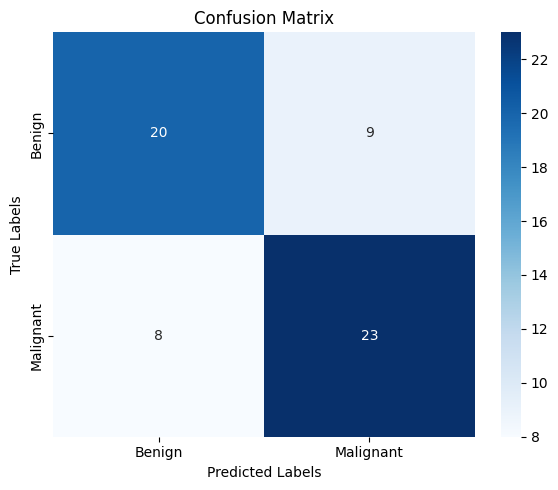

In [46]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predict the test set
Y_pred = model.predict(test_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Step 2: Get true labels
y_true = test_gen.classes

# Step 3: Class labels
class_labels = list(test_gen.class_indices.keys())

# Step 4: Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Step 5: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 6: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [47]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
overall_train_loss     = np.mean(train_loss)
overall_train_accuracy = np.mean(train_accuracy)
overall_val_loss       = np.mean(val_loss)
overall_val_accuracy   = np.mean(val_accuracy)

# Print the overall accuracy
print("Overall Training Accuracy:", overall_train_accuracy)
print("Overall Validation Accuracy:", overall_val_accuracy)


Overall Training Accuracy: 0.9093209480245908
Overall Validation Accuracy: 0.70703125


In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

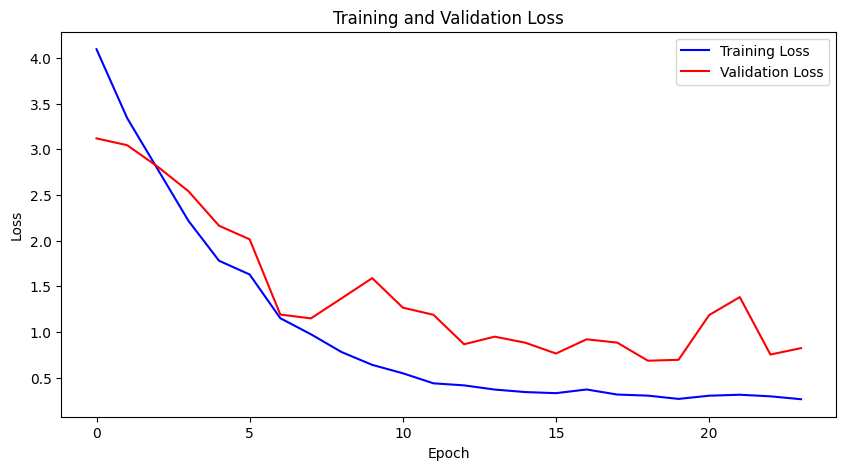

In [49]:

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss',   color='blue')
plt.plot(val_loss,   label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


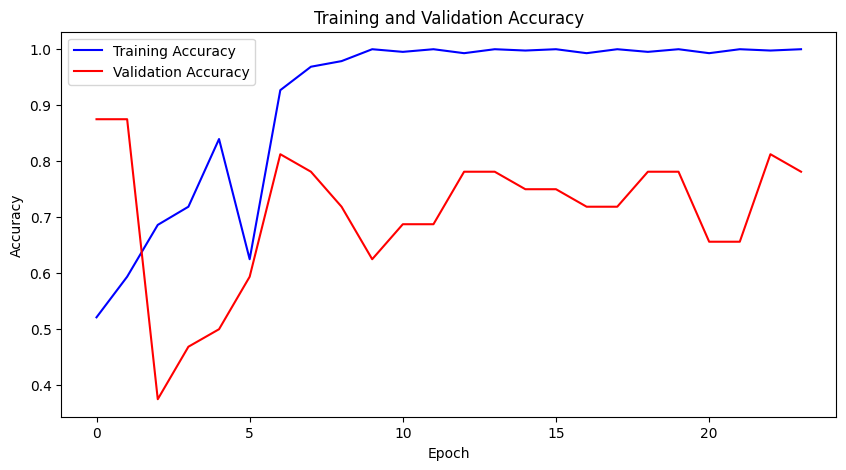

In [50]:

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy',   color='blue')
plt.plot(val_accuracy,   label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
model.save("/home/hamza/Downloads/final_model_using_class_weights.h5")

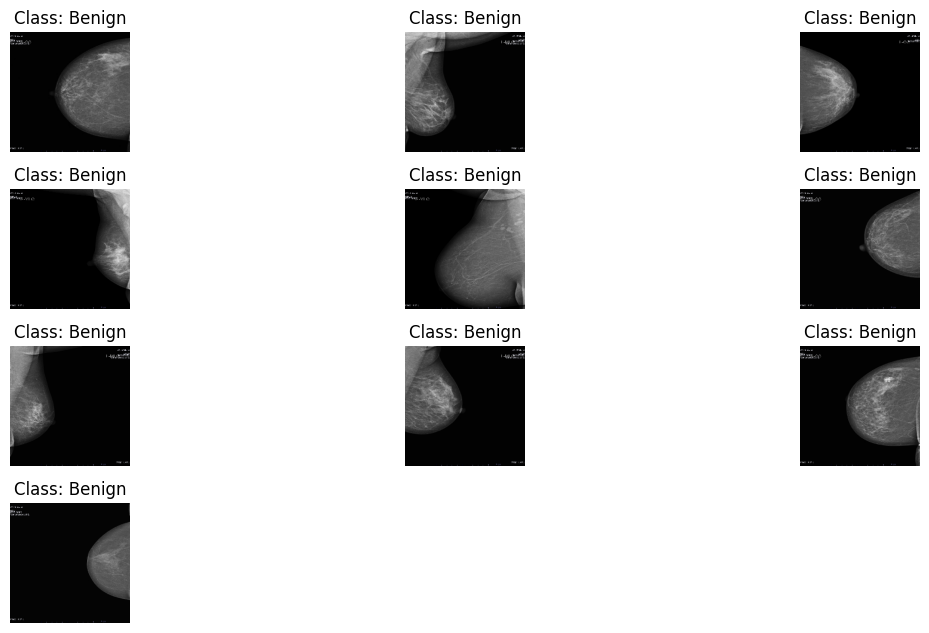

In [52]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the test generator
images, labels = next(test_gen)

# Define the number of images to display
num_images = 10

# Plot images
plt.figure(figsize=(12, 8))
for i in range(num_images):
    plt.subplot(5, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {class_labels[np.argmax(labels[i])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()